## <font color="Greenyellow">Trabajo de Fin Master 2: Modelos ensemble</font>
<a id="item0"></a> 

### <font color="Greenyellow">0. Indice</font>

* [1. Inicializacion del notebook](#item1)
* [2. ETL](#item2)
* [3. Ensemble Learning](#item3)

***
<a id="item1"></a>
### <font color="Greenyellow">1. Inicializacion del notebook</font>

#### <font color="Greenyellow">1.1. Importacion de librerias</font>

In [ ]:
# Analisis y transformacion de datos
import pandas as pd
import numpy as np
# Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns
# Base de datos
import sqlite3
# Funciones propias en carpeta 'funciones
import funciones.funciones as funciones
# funciones machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import learning_curve, cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
import lightgbm as lgb
# Modelos
import joblib
from sklearn.ensemble import StackingClassifier
from sklearn.calibration import CalibratedClassifierCV

#### <font color="Greenyellow">1.2. Parametros del notebook</font>

In [2]:
carpeta_base_datos = 'bbdd'
nombre_bbdd        = 'base_datos_tfm.db'
semilla = 12345
pct_test=0.20

***
<a id="item2"></a>
### <font color="Greenyellow">2. ETL</font>
[Volver al indice](#item0)

In [3]:
# importamos los datos
df = funciones.query_bbdd(carpeta_base_datos, nombre_bbdd='base_datos_tfm.db', query='SELECT * FROM meta_df')

In [4]:
# transformamos los datos y dividimos en train y test
X_train, X_test, y_train, y_test = funciones.preparar_datos(df, n_columnas_x=31, pct_test=pct_test, semilla=semilla)
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

X_train shape: (227845, 31), y_train shape: (227845,)
X_test shape: (56962, 31), y_test shape: (56962,)


In [5]:
best_params_rf = joblib.load('data/parametros/r_forest_best_params.pkl')
best_params_xgb = joblib.load('data/parametros/xgb_best_params.pkl')
best_params_rl = joblib.load('data/parametros/r_logistica_best_params.pkl')
best_params_lgb = joblib.load('data/parametros/lgbm_best_params.pkl')

***
<a id="item3"></a>
### <font color="Greenyellow">3. Ensemble Learning (stacking)</font>
[Volver al indice](#item0)

Sin calibrado

1. Inicio del entrenamiento...
... entrenamiento completado.
2. Generando metricas de evaluacion:
    A. Precisión del modelo: 0.9996
    B. F1 Score: 0.8810
    C. AUC: 0.9426
    D. Recall (Sensibilidad) Clase Minoritaria (1): 0.8222
    E. Metricas desagregadas:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56872
           1       0.95      0.82      0.88        90

    accuracy                           1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962



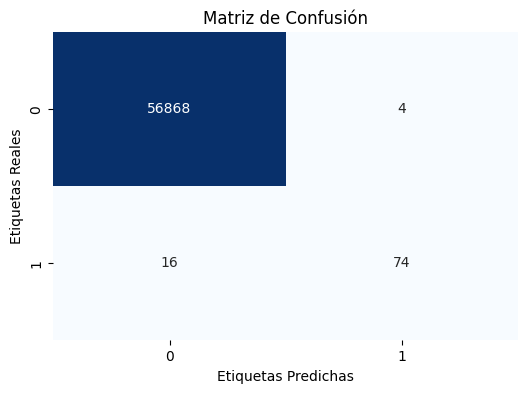

In [7]:
# 1. Definimos los modelos a ensamblar
model_1 = RandomForestClassifier(**best_params_rf, random_state=semilla, n_jobs=-1)
model_2 = xgb.XGBClassifier(**best_params_xgb, objective='binary:logistic', use_label_encoder=False, eval_metric='aucpr', verbosity=0)
base_model = LogisticRegression(**best_params_rl, solver='liblinear', random_state=semilla)
model_3 = BaggingClassifier(estimator=base_model, n_estimators=10, random_state=semilla, n_jobs=-1)
model_4 = lgb.LGBMClassifier(**best_params_lgb, objective='binary', random_state=semilla, n_jobs=-1)

# 2. Definimos el meta-modelo
meta_model = RandomForestClassifier(n_estimators=200, random_state=semilla, n_jobs=-1)

# 3. Ensamblamos los modelos instanciando el  StackingClassifier
stacking_model = StackingClassifier(
    estimators=[('rf', model_1), ('xgb', model_2), ('rl', model_3), ('lgbm', model_4)],
    final_estimator=meta_model,
    cv=3,
    n_jobs=-1
)

# 4. Entrenamiento del Ensemble
print("1. Inicio del entrenamiento...")
stacking_model.fit(X_train, y_train)
print("... entrenamiento completado.")

# 5. Evaluación del Ensemble
print("2. Generando metricas de evaluacion:")
accuracy, f1, auc, recall_minoritaria, metricas_desagregadas, c_matrix = funciones.evaluar_modelo(stacking_model, X_test, y_test)

Con calibrado y umbral 0.5

Calibrando modelos base...
1. Inicio del entrenamiento...
... entrenamiento completado.
Evaluando con umbral ajustado: 0.5
2. Generando metricas de evaluacion:
    A. Precisión del modelo: 0.9997
    B. F1 Score: 0.8820
    C. AUC: 0.9909
    D. Recall (Sensibilidad) Clase Minoritaria (1): 0.7889 (Umbral Ajustado)
    E. Metricas desagregadas:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56872
           1       1.00      0.79      0.88        90

    accuracy                           1.00     56962
   macro avg       1.00      0.89      0.94     56962
weighted avg       1.00      1.00      1.00     56962



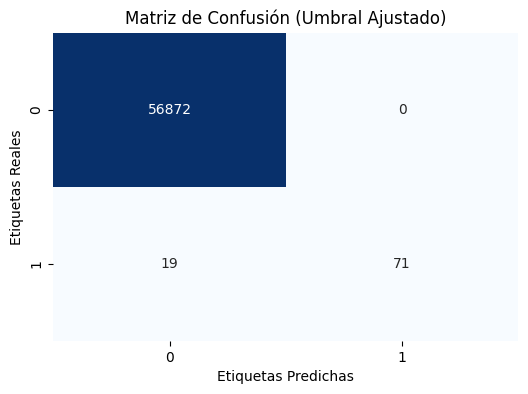

    A. Precisión del modelo: 0.9997
    B. F1 Score: 0.8820
    C. AUC: 0.9909
    D. Recall (Sensibilidad) Clase Minoritaria (1): 0.7889
    E. Metricas desagregadas:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56872
           1       1.00      0.79      0.88        90

    accuracy                           1.00     56962
   macro avg       1.00      0.89      0.94     56962
weighted avg       1.00      1.00      1.00     56962



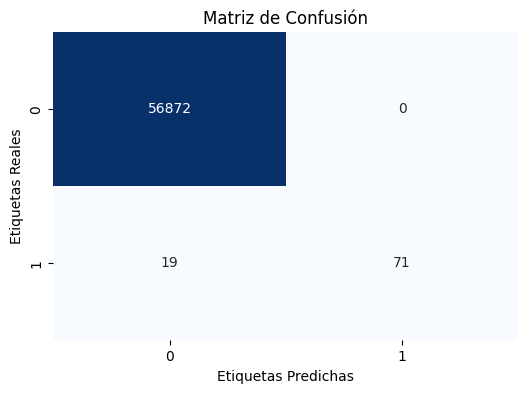

In [ ]:
# 1. Definimos los modelos a ensamblar
model_1 = RandomForestClassifier(**best_params_rf, random_state=semilla, n_jobs=-1)
model_2 = xgb.XGBClassifier(**best_params_xgb, objective='binary:logistic', use_label_encoder=False, eval_metric='aucpr', verbosity=0)
base_model = LogisticRegression(**best_params_rl, solver='liblinear', random_state=semilla)
model_3 = BaggingClassifier(estimator=base_model, n_estimators=10, random_state=semilla, n_jobs=-1)
model_4 = lgb.LGBMClassifier(**best_params_lgb, objective='binary', random_state=semilla, n_jobs=-1)

# 2. Calibramos los modelos base
print("Calibrando modelos base...")
# RandomForestClassifier
calibrated_rf = CalibratedClassifierCV(model_1, method='isotonic', cv=3, n_jobs=-1)
calibrated_xgb = CalibratedClassifierCV(model_2, method='isotonic', cv=3, n_jobs=-1)
calibrated_reglog = CalibratedClassifierCV(model_3, method='isotonic', cv=3, n_jobs=-1)
calibrated_lgbm = CalibratedClassifierCV(model_4, method='isotonic', cv=3, n_jobs=-1)

# 2. Definimos el meta-modelo
meta_model = meta_model = LogisticRegression(solver='liblinear', random_state=semilla)

# 3. Ensamblamos los modelos instanciando el  StackingClassifier
stacking_model = StackingClassifier(
    estimators=[('rf', calibrated_rf),
                ('xgb_1', calibrated_xgb),
                ('rl_1', calibrated_reglog),
                ('lgbm', calibrated_lgbm)],
    final_estimator=meta_model, cv=3, n_jobs=-1, stack_method='predict_proba')

# 4. Entrenamiento del Ensemble
print("1. Inicio del entrenamiento...")
stacking_model.fit(X_train, y_train)
print("... entrenamiento completado.")

# 5. Evaluación del Ensemble

y_pred_proba = stacking_model.predict_proba(X_test)[:, 1]
umbral_recall_optimo = 0.50
y_pred_umbral_ajustado = (y_pred_proba >= umbral_recall_optimo).astype(int)
y_pred_ajustado = (y_pred_proba >= umbral_recall_optimo).astype(int)
print(f"Evaluando con umbral ajustado: {umbral_recall_optimo}")

print("2. Generando metricas de evaluacion:")
# accuracy, f1, auc, recall_minoritaria, metricas_desagregadas, c_matrix = funciones.evaluar_modelo(stacking_model, X_test, y_test)
accuracy, f1, auc, recall_minoritaria, metricas_desagregadas, c_matrix = funciones.evaluar_modelo_ajustado(y_test, y_pred_ajustado, y_pred_proba)
accuracy_def, f1_def, auc_def, recall_minoritaria_def, metricas_desagregadas_def, c_matrix_def = funciones.evaluar_modelo(stacking_model, X_test, y_test)

Con calibrado y umbral 0.1

Calibrando modelos base...
1. Inicio del entrenamiento...
... entrenamiento completado.
Evaluando con umbral ajustado: 0.1
2. Generando metricas de evaluacion:
    A. Precisión del modelo: 0.9997
    B. F1 Score: 0.8848
    C. AUC: 0.9909
    D. Recall (Sensibilidad) Clase Minoritaria (1): 0.8111 (Umbral Ajustado)
    E. Metricas desagregadas:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56872
           1       0.97      0.81      0.88        90

    accuracy                           1.00     56962
   macro avg       0.99      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962



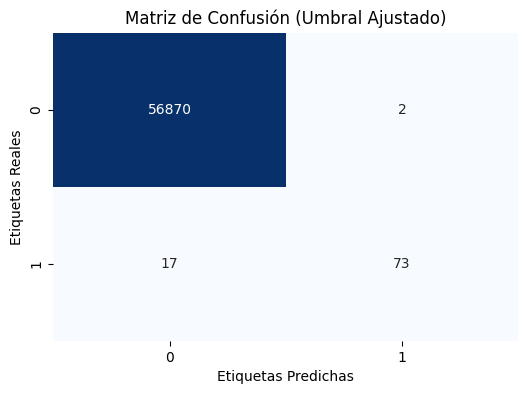

    A. Precisión del modelo: 0.9997
    B. F1 Score: 0.8820
    C. AUC: 0.9909
    D. Recall (Sensibilidad) Clase Minoritaria (1): 0.7889
    E. Metricas desagregadas:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56872
           1       1.00      0.79      0.88        90

    accuracy                           1.00     56962
   macro avg       1.00      0.89      0.94     56962
weighted avg       1.00      1.00      1.00     56962



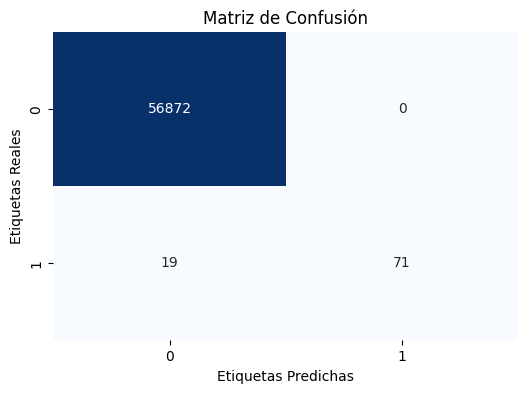

In [ ]:
# 1. Definimos los modelos a ensamblar
model_1 = RandomForestClassifier(**best_params_rf, random_state=semilla, n_jobs=-1)
model_2 = xgb.XGBClassifier(**best_params_xgb, objective='binary:logistic', use_label_encoder=False, eval_metric='aucpr', verbosity=0)
base_model = LogisticRegression(**best_params_rl, solver='liblinear', random_state=semilla)
model_3 = BaggingClassifier(estimator=base_model, n_estimators=10, random_state=semilla, n_jobs=-1)
model_4 = lgb.LGBMClassifier(**best_params_lgb, objective='binary', random_state=semilla, n_jobs=-1)

# 2. Calibramos los modelos base
print("Calibrando modelos base...")
# RandomForestClassifier
calibrated_rf = CalibratedClassifierCV(model_1, method='isotonic', cv=3, n_jobs=-1)
calibrated_xgb = CalibratedClassifierCV(model_2, method='isotonic', cv=3, n_jobs=-1)
calibrated_reglog = CalibratedClassifierCV(model_3, method='isotonic', cv=3, n_jobs=-1)
calibrated_lgbm = CalibratedClassifierCV(model_4, method='isotonic', cv=3, n_jobs=-1)

# 2. Definimos el meta-modelo
meta_model = meta_model = LogisticRegression(solver='liblinear', random_state=semilla)

# 3. Ensamblamos los modelos instanciando el  StackingClassifier
stacking_model = StackingClassifier(
    estimators=[('rf', calibrated_rf),
                ('xgb_1', calibrated_xgb),
                ('rl_1', calibrated_reglog),
                ('lgbm', calibrated_lgbm)],
    final_estimator=meta_model, cv=3, n_jobs=-1, stack_method='predict_proba')

# 4. Entrenamiento del Ensemble
print("1. Inicio del entrenamiento...")
stacking_model.fit(X_train, y_train)
print("... entrenamiento completado.")

# 5. Evaluación del Ensemble

y_pred_proba = stacking_model.predict_proba(X_test)[:, 1]
umbral_recall_optimo = 0.10
y_pred_umbral_ajustado = (y_pred_proba >= umbral_recall_optimo).astype(int)
y_pred_ajustado = (y_pred_proba >= umbral_recall_optimo).astype(int)
print(f"Evaluando con umbral ajustado: {umbral_recall_optimo}")

print("2. Generando metricas de evaluacion:")
# accuracy, f1, auc, recall_minoritaria, metricas_desagregadas, c_matrix = funciones.evaluar_modelo(stacking_model, X_test, y_test)
accuracy, f1, auc, recall_minoritaria, metricas_desagregadas, c_matrix = funciones.evaluar_modelo_ajustado(y_test, y_pred_ajustado, y_pred_proba)
accuracy_def, f1_def, auc_def, recall_minoritaria_def, metricas_desagregadas_def, c_matrix_def = funciones.evaluar_modelo(stacking_model, X_test, y_test)

***
[Volver al indice](#item0)

Con calibrado y umbral 0.01

Calibrando modelos base...
1. Inicio del entrenamiento...
... entrenamiento completado.
Evaluando con umbral ajustado: 0.01
2. Generando metricas de evaluacion:
    A. Precisión del modelo: 0.9996
    B. F1 Score: 0.8800
    C. AUC: 0.9909
    D. Recall (Sensibilidad) Clase Minoritaria (1): 0.8556 (Umbral Ajustado)
    E. Metricas desagregadas:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56872
           1       0.91      0.86      0.88        90

    accuracy                           1.00     56962
   macro avg       0.95      0.93      0.94     56962
weighted avg       1.00      1.00      1.00     56962



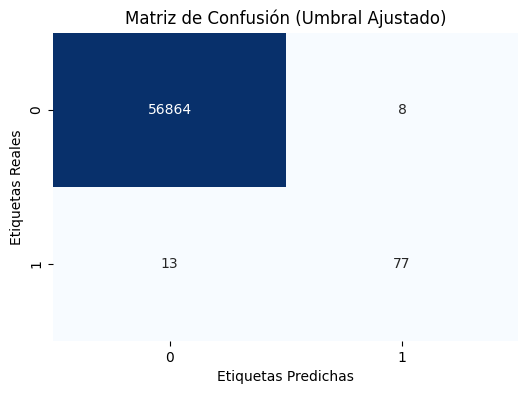

    A. Precisión del modelo: 0.9997
    B. F1 Score: 0.8820
    C. AUC: 0.9909
    D. Recall (Sensibilidad) Clase Minoritaria (1): 0.7889
    E. Metricas desagregadas:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56872
           1       1.00      0.79      0.88        90

    accuracy                           1.00     56962
   macro avg       1.00      0.89      0.94     56962
weighted avg       1.00      1.00      1.00     56962



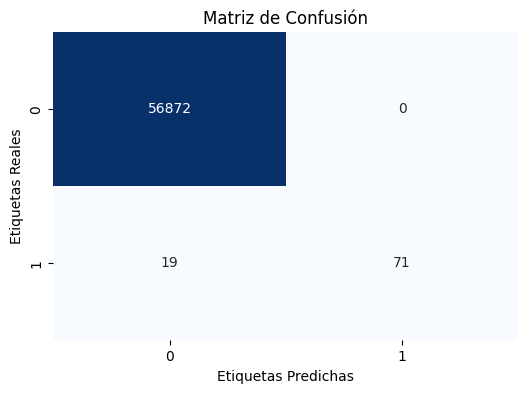

In [12]:
# 1. Definimos los modelos a ensamblar
model_1 = RandomForestClassifier(**best_params_rf, random_state=semilla, n_jobs=-1)
model_2 = xgb.XGBClassifier(**best_params_xgb, objective='binary:logistic', use_label_encoder=False, eval_metric='aucpr', verbosity=0)
base_model = LogisticRegression(**best_params_rl, solver='liblinear', random_state=semilla)
model_3 = BaggingClassifier(estimator=base_model, n_estimators=10, random_state=semilla, n_jobs=-1)
model_4 = lgb.LGBMClassifier(**best_params_lgb, objective='binary', random_state=semilla, n_jobs=-1)

# 2. Calibramos los modelos base
print("Calibrando modelos base...")
# RandomForestClassifier
calibrated_rf = CalibratedClassifierCV(model_1, method='isotonic', cv=3, n_jobs=-1)
calibrated_reglog = CalibratedClassifierCV(model_3, method='isotonic', cv=3, n_jobs=-1)
calibrated_xgb = CalibratedClassifierCV(model_2, method='isotonic', cv=3, n_jobs=-1)
calibrated_lgbm = CalibratedClassifierCV(model_4, method='isotonic', cv=3, n_jobs=-1)


# 2. Definimos el meta-modelo
meta_model = meta_model = LogisticRegression(solver='liblinear', random_state=semilla)

# 3. Ensamblamos los modelos instanciando el  StackingClassifier
stacking_model = StackingClassifier(
    estimators=[('rf', calibrated_rf),
                ('xgb_1', calibrated_xgb),
                ('rl_1', calibrated_reglog),
                ('lgbm', calibrated_lgbm)],
    final_estimator=meta_model, cv=3, n_jobs=-1, stack_method='predict_proba')

# 4. Entrenamiento del Ensemble
print("1. Inicio del entrenamiento...")
stacking_model.fit(X_train, y_train)
print("... entrenamiento completado.")

# 5. Evaluación del Ensemble

y_pred_proba = stacking_model.predict_proba(X_test)[:, 1]
umbral_recall_optimo = 0.01
y_pred_umbral_ajustado = (y_pred_proba >= umbral_recall_optimo).astype(int)
y_pred_ajustado = (y_pred_proba >= umbral_recall_optimo).astype(int)
print(f"Evaluando con umbral ajustado: {umbral_recall_optimo}")

print("2. Generando metricas de evaluacion:")
# accuracy, f1, auc, recall_minoritaria, metricas_desagregadas, c_matrix = funciones.evaluar_modelo(stacking_model, X_test, y_test)
accuracy, f1, auc, recall_minoritaria, metricas_desagregadas, c_matrix = funciones.evaluar_modelo_ajustado(y_test, y_pred_ajustado, y_pred_proba)
accuracy_def, f1_def, auc_def, recall_minoritaria_def, metricas_desagregadas_def, c_matrix_def = funciones.evaluar_modelo(stacking_model, X_test, y_test)

